In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [2]:
# Преобразования для данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Загрузка данных
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Создание DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

100%|████████████████████████████████████████| 170M/170M [00:27<00:00, 6.20MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [51]:
import torch.nn.functional as F

class MambaBlock(nn.Module):
    def __init__(self, d_input, d_model):
        super(MambaBlock, self).__init__()
        self.in_proj = nn.Linear(d_input, d_model)
        self.s_B = nn.Linear(d_model, d_model)
        self.s_C = nn.Linear(d_model, d_model)
        self.norm = nn.BatchNorm1d(d_model)  # Добавим LayerNorm
        self.out_proj = nn.Linear(d_model, d_input)

    def forward(self, x):
        x = self.in_proj(x)
        x = F.relu(x)  # Добавим нелинейность
        B, C = self.s_B(x), self.s_C(x)
        x = x + B + C
        x = self.norm(x)  # Применим нормализацию
        return self.out_proj(x)

class Mamba(nn.Module):
    def __init__(self, num_layers, d_input, d_model):
        super(Mamba, self).__init__()
        self.layers = nn.ModuleList([MambaBlock(d_input, d_model) for _ in range(num_layers)])
        self.final_norm = nn.LayerNorm(d_input)  # Финальная нормализация

    def forward(self, seq):
        for mamba in self.layers:
            seq = mamba(seq)
        seq = self.final_norm(seq)  # Применим финальную нормализацию
        return seq

# Инициализация модели
model = Mamba(num_layers=10, d_input=32*32*3, d_model=512)  # Увеличим d_model до 512

In [52]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for data, target in loader:
            data = data.view(data.size(0), -1)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total_samples += data.size(0)

    accuracy = 100. * correct / total_samples
    return accuracy

In [53]:
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
step_total = 0
epochs = 3
losses = []
accs = []

for e in range(epochs):
    model.train()
    acc_loss = 0.0
    batches = len(train_loader)
    for xb, yb in train_loader:
        xb = xb.view(xb.size(0), -1)
        opt.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        opt.step()

        acc_loss += loss.item()
        step_total += 1
        if step_total % 100 == 0:
            print(f"[{e+1}/{epochs}] #{step_total}/{batches} → L={acc_loss/100:.4f}")
            losses.append(acc_loss/100)
            acc_loss = 0.0
        if step_total % 300 == 0:
            accs.append(evaluate(model, test_loader))
            model.train()

    # остаток, если батчей не делится на interval
    rem = step_total % 100
    if rem:
        print(f"[{e+1}/{epochs}] #{step_total}/{batches} → L={acc_loss/rem:.4f}")

[1/3] #100/1563 → L=3.5143
[1/3] #200/1563 → L=2.6336
[1/3] #300/1563 → L=2.4759
[1/3] #400/1563 → L=2.3876
[1/3] #500/1563 → L=2.2923
[1/3] #600/1563 → L=2.2276
[1/3] #700/1563 → L=2.1655
[1/3] #800/1563 → L=2.1324
[1/3] #900/1563 → L=2.1235
[1/3] #1000/1563 → L=2.1049
[1/3] #1100/1563 → L=2.0595
[1/3] #1200/1563 → L=2.0559
[1/3] #1300/1563 → L=2.0758
[1/3] #1400/1563 → L=2.0851
[1/3] #1500/1563 → L=2.0665
[1/3] #1563/1563 → L=2.0526
[2/3] #1600/1563 → L=0.7708
[2/3] #1700/1563 → L=2.0356
[2/3] #1800/1563 → L=2.0391
[2/3] #1900/1563 → L=2.0262
[2/3] #2000/1563 → L=2.0583
[2/3] #2100/1563 → L=2.0236
[2/3] #2200/1563 → L=2.0207
[2/3] #2300/1563 → L=2.0277
[2/3] #2400/1563 → L=2.0001
[2/3] #2500/1563 → L=2.0349
[2/3] #2600/1563 → L=2.0067
[2/3] #2700/1563 → L=2.0085
[2/3] #2800/1563 → L=1.9693
[2/3] #2900/1563 → L=1.9704
[2/3] #3000/1563 → L=1.9512
[2/3] #3100/1563 → L=1.9894
[2/3] #3126/1563 → L=1.9482
[3/3] #3200/1563 → L=1.4460
[3/3] #3300/1563 → L=1.9579
[3/3] #3400/1563 → L=1.9543
[

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


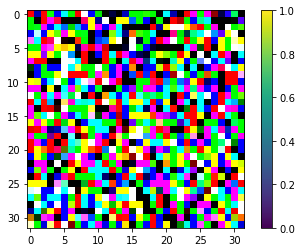

In [54]:
import matplotlib.pyplot as plt

# Функция для захвата активаций
def hook_fn(module, input, output):
    activations.append(output)

# Регистрируем хук для одного из слоев
activations = []
hook = model.layers[0].register_forward_hook(hook_fn)

# Проход через модель
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.view(images.size(0), -1)
        _ = model(images)
        break

# Визуализация активаций
activation = activations[0].mean(dim=0).detach().numpy()
plt.imshow(activation.reshape(32, 32, 3))
plt.colorbar()
plt.show()

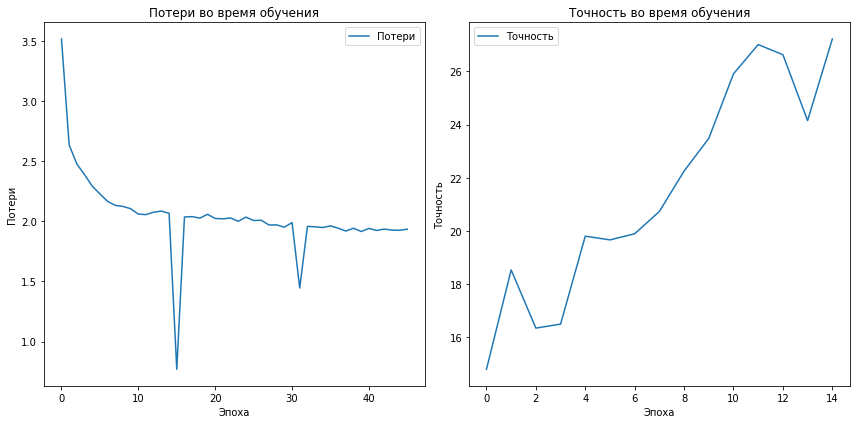

In [56]:
# Графики потерь и точности
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(losses, label='Потери')
plt.title('Потери во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accs, label='Точность')
plt.title('Точность во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

plt.tight_layout()
plt.show()

Точность вышла не очень хорошей, возможно нужно увеличить количество слоев и в целом параметры модели, матрицу же можно интерпретировать как места на картинке, которые оказывают наибольшее влияние на результат.